In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import os
import json

from torch.utils.data import DataLoader, Dataset
from PIL import Image

from torchinfo import summary
import torch.optim as optim
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter

import glob
import random
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Training settings
batch_size = 4
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42
image_size = (3,256,256)
sequence_length = 16

# DATASET

16 sequence image를 1개의 input으로 생각 > 16개의 이미지에 대해 1개의 label이 나오도록 함

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
with open(r'train_list.txt', 'r') as f:
    data = f.read()
file_list = data.splitlines()

In [9]:
with open(r'label_list.txt', 'r') as f:
    data = f.read()
label_list = data.splitlines()

In [19]:
train_list, valid_list, train_label_list, valid_label_list = train_test_split(file_list, 
                                                                              label_list,
                                                                              test_size=0.3,
                                                                              stratify=label_list,
                                                                              random_state=seed)

In [16]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")

Train Data: 3
Validation Data: 2


In [90]:
from torchvision import datasets, transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)



In [121]:
class SeqDataset(Dataset):
    def __init__(self,file_list,label_list,transform=None):
        self.file_list = file_list
        self.label_list= label_list
        self.transform = transform
        self.fps = 30
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        
        x_seq=torch.empty((sequence_length,3,224,224))
        y = torch.empty((1))
        
        img_path = self.file_list[idx]
        
        y = int(self.label_list[idx])
        
        file_num = int(img_path[-9:-4])
        for i in range(sequence_length):
            sequence_num = file_num+i*self.fps
            sequence_num = str(sequence_num).zfill(5)
            img_path = img_path[:-9]+sequence_num+".jpg"
            img = Image.open(img_path)
            img_transformed = self.transform(img)
            x_seq[i] = img_transformed
        return x_seq,y


In [122]:
train_data = SeqDataset(train_list, train_label_list,transform=train_transforms)
valid_data = SeqDataset(valid_list, valid_label_list, transform=val_transforms)

In [123]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True,drop_last=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True,drop_last=True)

In [124]:
for i, (x,y) in enumerate(train_loader):
    print("== Batch, Sequence, Channel, Height, Width ==")
    print(x.shape)
    print("== Class ==")
    print(y.shape)
    break

==Batch, Sequence, Channel, Height, Width==
torch.Size([2, 16, 3, 224, 224])
tensor([0, 1])
torch.Size([2])


In [125]:
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

class CNNLSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
        super().__init__()
        
        ## embedding with cnn
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        
#         self.cnn = VGG19()
        self.cnn = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Replace last layer
        self.cnn._fc = nn.Sequential(nn.Linear(self.cnn._fc.in_features, 512), 
                                         nn.ReLU(),  
                                         nn.Dropout(0.25))
        
        self.lstm = nn.LSTM(input_dim,hidden_dim,layer_dim,batch_first=True)
        
        self.fc = nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,x):
        # num_layers*bidirectional, batch_size, n_hidden)
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, requires_grad=True).to(device)
        cell = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, requires_grad=True).to(device)
        
        batchsize, time_steps,C,H,W = x.size()
        c_in = x.view(batchsize * time_steps,C,H,W)
        
        with torch.no_grad():
            c_out = self.cnn(c_in)
        r_in = c_out.view(batchsize, time_steps, -1)
        
        
        ### r_in -> [Batch, sequence length, input dimension(512)]
        r_out,(hn,cn) = self.lstm(r_in,(hidden,cell))
        
        ### r_out -> [batch, sequeence, 128]
        ### with batch_first = True, we want to predict by last sequence data. so, [batch,-1,output] Linear with class num.
        x = self.fc(r_out[:,-1,:])
        
        return x

In [126]:
input_dim = 512
hidden_dim = 128
layer_dim = 1
output_dim = 101

In [127]:
model = CNNLSTM(input_dim,hidden_dim,layer_dim,output_dim).to(device)

Loaded pretrained weights for efficientnet-b0


In [128]:
summary(model,(batch_size,sequence_length,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
CNNLSTM                                                 --                        --
├─EfficientNet: 1                                       --                        --
│    └─ModuleList: 2-1                                  --                        --
├─EfficientNet: 1-1                                     [64, 512]                 --
│    └─Conv2dStaticSamePadding: 2-2                     [64, 32, 112, 112]        --
│    │    └─ZeroPad2d: 3-1                              [64, 3, 225, 225]         --
│    └─BatchNorm2d: 2-3                                 [64, 32, 112, 112]        64
│    └─MemoryEfficientSwish: 2-4                        [64, 32, 112, 112]        --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─MBConvBlock: 3-2                            [64, 16, 112, 112]        1,448
│    │    └─MBConvBlock: 3-3                            [

In [129]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)

In [130]:
writer= SummaryWriter('runs/cnn-lstm')

# Show Image

In [151]:
def im_convert(tensor):
    image = tensor.clone().to(device='cpu').numpy()
    image = image.transpose(0,2,3,1)
    image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
    image = image.clip(0, 1)
    return image

tensor(1)


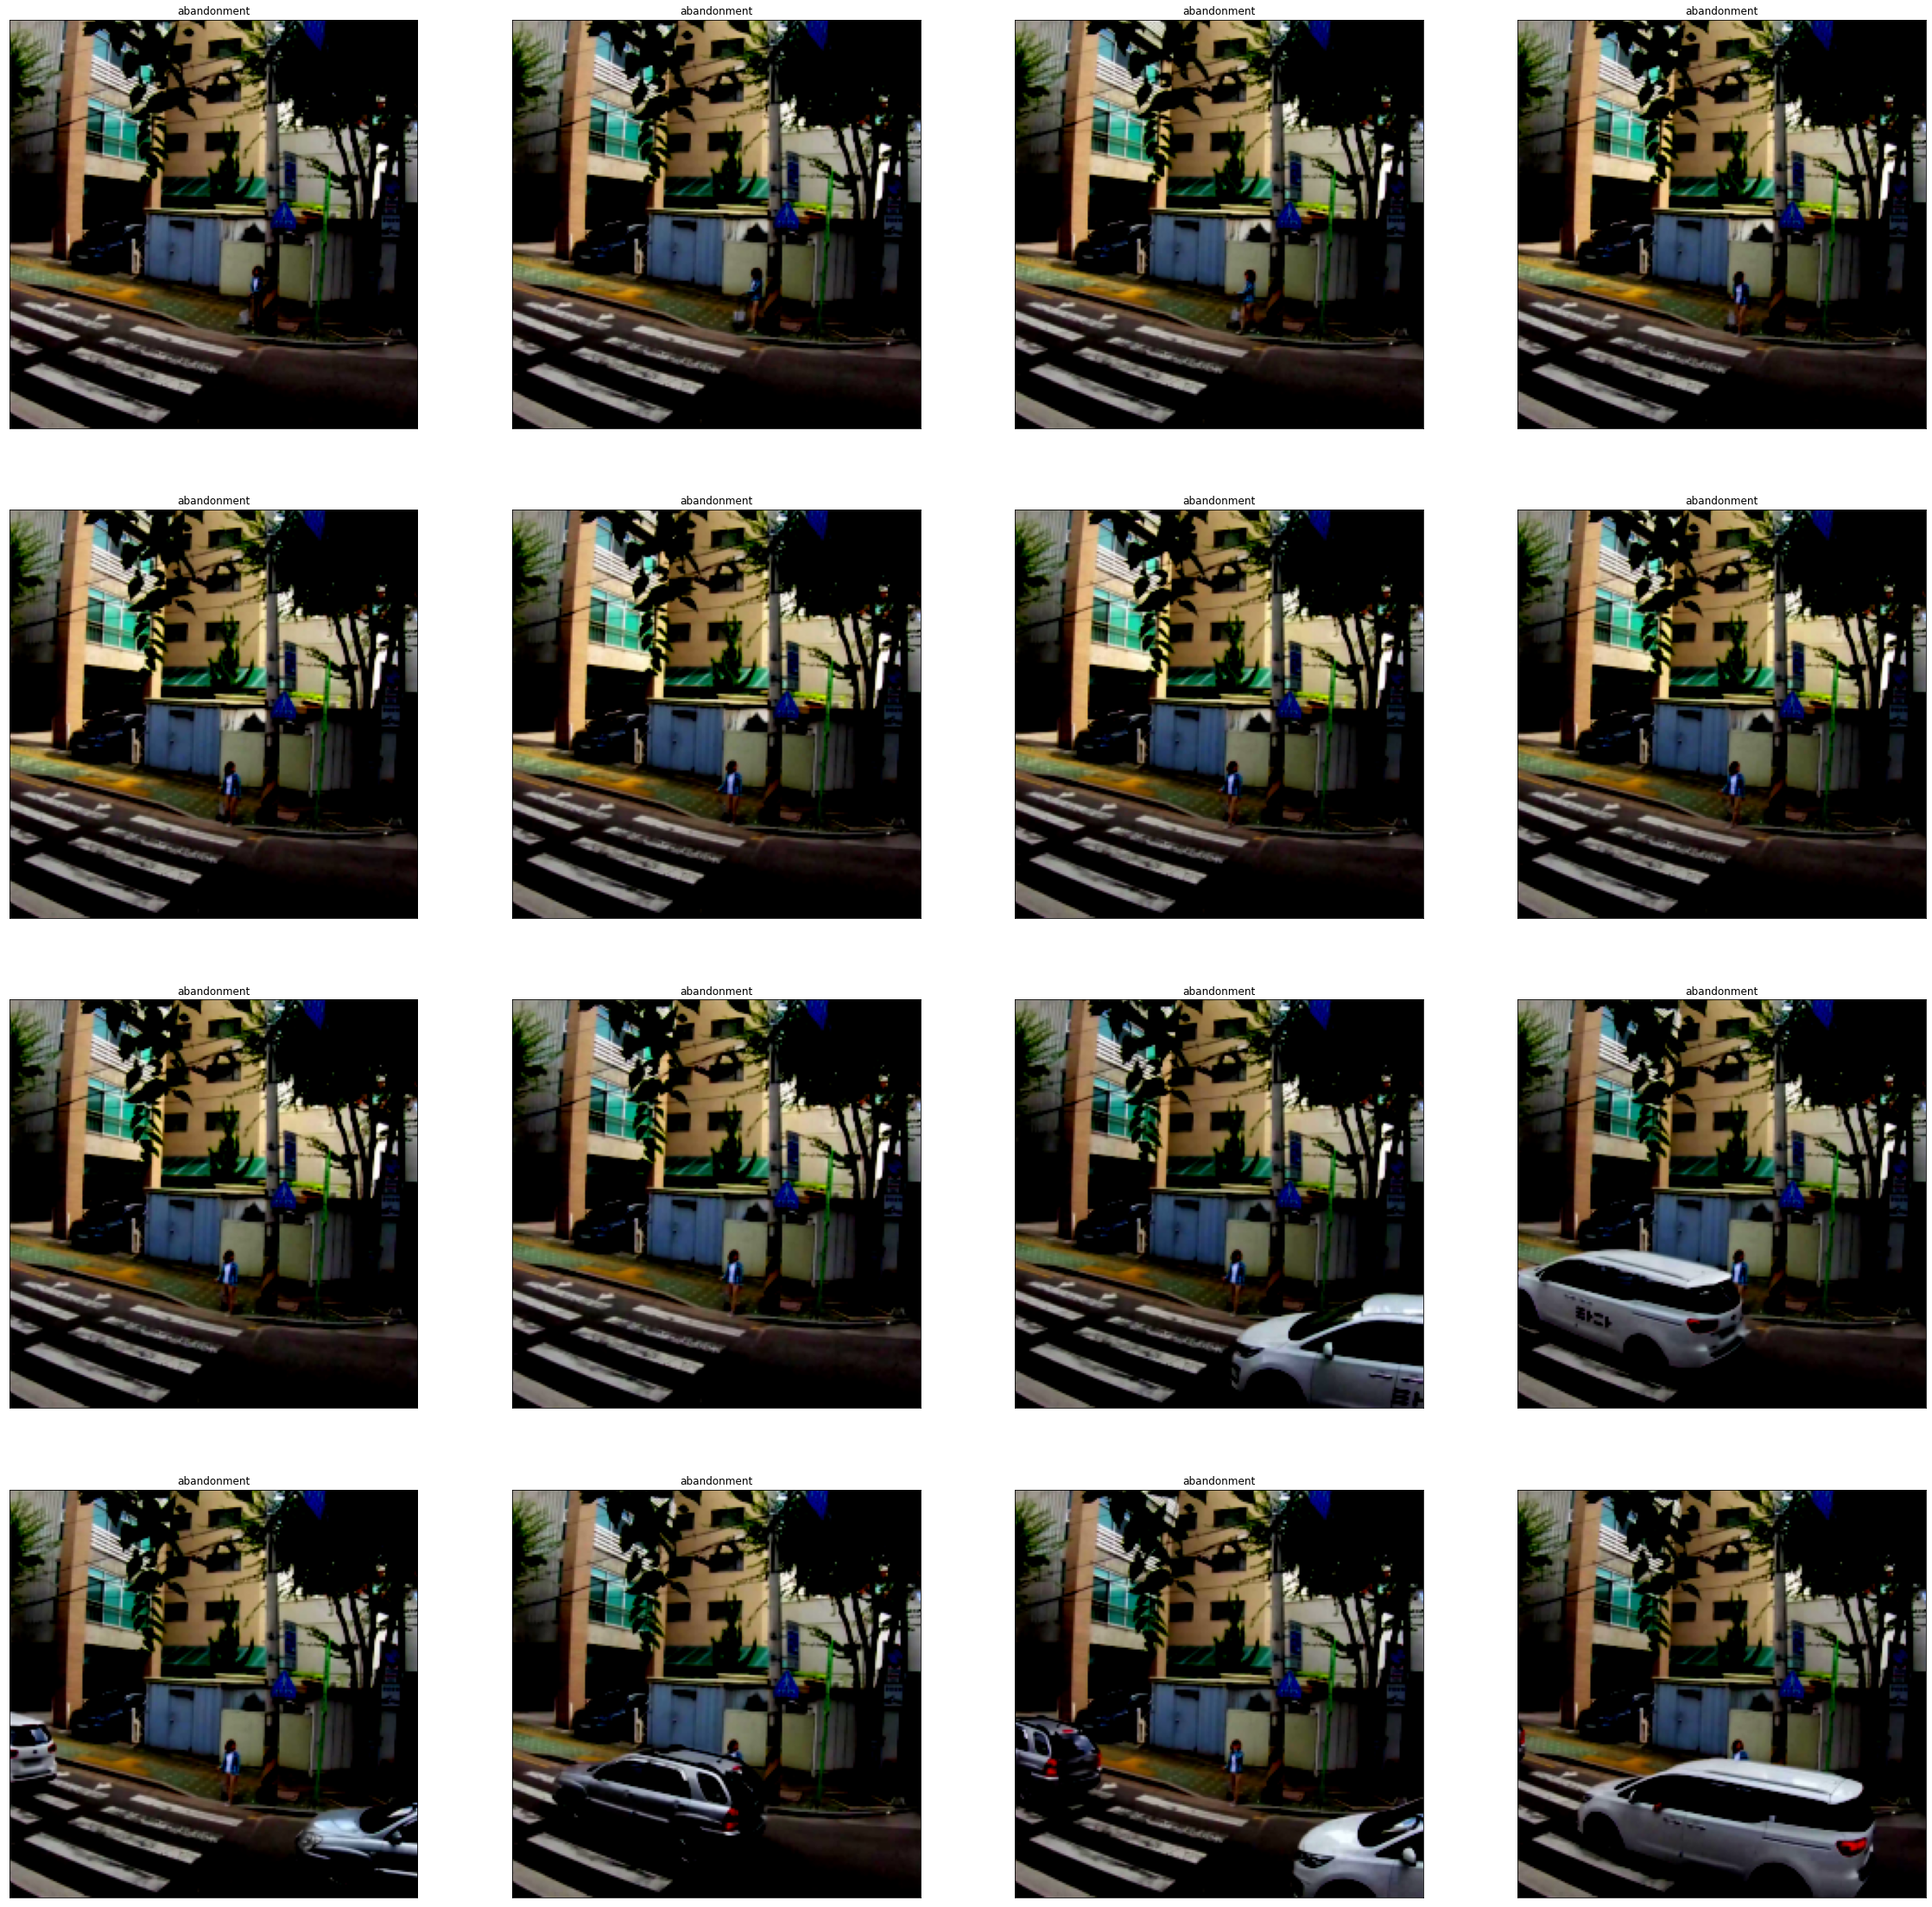

In [152]:
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'

rows = 1
cols = 20
fig=plt.figure(figsize=(40,40))

img,label = next(iter(valid_loader))

# print(img)
print(label[0])
label = label[0].numpy()
for i in range(4):
    ax.set_title('abandonment' if label != 0 else 'abandonment X')
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(img[0])[i])
    
for i in range(4):
    ax.set_title('abandonment' if label != 0 else 'abandonment X')
    ax = fig.add_subplot(4, 4, i+5, xticks=[], yticks=[])
    plt.imshow(im_convert(img[0])[i+4])
    
for i in range(4):
    ax.set_title('abandonment' if label != 0 else 'abandonment X')
    ax = fig.add_subplot(4, 4, i+9, xticks=[], yticks=[])
    plt.imshow(im_convert(img[0])[i+8])
    
for i in range(4):
    ax.set_title('abandonment' if label != 0 else 'abandonmentX')
    ax = fig.add_subplot(4, 4, i+13, xticks=[], yticks=[])
    plt.imshow(im_convert(img[0])[i+12])

In [38]:
# # for continue
# model.load_state_dict(torch.load(r'C:\Users\CHOISJ-DT01\Desktop\cnn_lstm_save_10.pth'))

<All keys matched successfully>

In [39]:
for epoch in range(5):
    epoch_loss = 0
    epoch_acc = 0
    
    for data,label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device, dtype=torch.long)
                         
        output = model(data)
        
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_loss += loss / len(train_loader)
        epoch_acc += acc /len(train_loader)
        
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device, dtype=torch.long)

            val_output = model(data)
            
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        writer.add_scalar('validation_loss',epoch_val_loss,epoch+38)

    writer.add_scalar('training_loss',epoch_loss,epoch+38)


    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_acc:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
        
        

  0%|          | 0/27151 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4951 - acc: 0.6052 - val_loss : 1.7163 - val_acc: 0.5488



  0%|          | 0/27151 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.4843 - acc: 0.6081 - val_loss : 1.6969 - val_acc: 0.5549



  0%|          | 0/27151 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.4692 - acc: 0.6115 - val_loss : 1.6831 - val_acc: 0.5577



  0%|          | 0/27151 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.4620 - acc: 0.6138 - val_loss : 1.6593 - val_acc: 0.5627



  0%|          | 0/27151 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.4444 - acc: 0.6157 - val_loss : 1.6625 - val_acc: 0.5606



In [40]:
torch.save(model.state_dict(), r"abandonment.pth")

In [41]:
data, label = next(iter(valid_loader))

In [42]:
data = data.to(device)
label = label.to(device)

In [43]:
result = model(data)
result_loss = criterion(result,label)

In [46]:
# for i,pred in enumerate(result.to(device = 'cpu').argmax(dim=1).numpy()):
#     print("prediction : "+ str([k for k,v in annotation_dict.items() if v == pred][0]))
#     print("gt : "+ str([k for k,v in annotation_dict.items() if v == label[i].to(device='cpu').numpy()][0]))
    
# #     print(annotation_dict.values()==pred)

prediction : TableTennisShot
gt : TableTennisShot
prediction : Hammering
gt : RockClimbingIndoor
prediction : HorseRiding
gt : HorseRiding
prediction : PlayingGuitar
gt : BlowDryHair
